# AT&T Spam Detector Project

## IMPORT LIBRARIES

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, GlobalAveragePooling1D, GRU, SimpleRNN
from wordcloud import WordCloud

import tensorflow as tf

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

2024-08-16 16:44:08.084425: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## IMPORT DATA

In [2]:
df = pd.read_csv('spam.csv', encoding='latin1')
df

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


## EXPLORE DATA

In [3]:
df.describe()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)"""
freq,4825,30,3,2,2


Il y a trois colonnes inutiles que nous devrions supprimer.

In [4]:
"""
Dans ce block de code, nous travaillons avec un DataFrame 'df' qui contient des messages de spam potentiels.

Les colonnes 'Unnamed: 2', 'Unnamed: 3' et 'Unnamed: 4' contiennent des segments de texte supplémentaires pour certains mails qui ont été divisés entre plusieurs colonnes. 

Premièrement, pour chaque colonne non nommée 'Unnamed: 2', 'Unnamed: 3', et 'Unnamed: 4', on remplace les valeurs manquantes par des chaînes de caractères vides "". C'est pour éviter les erreurs lors de la concaténation de ces colonnes.

Ensuite, on concatène les données de ces colonnes non-nommées avec la colonne 'v2' qui contient la majorité du contenu des mails. L'idée est de rassembler tout le texte en une seule colonne. 

On utilise `ignore_index=True` pour ne pas garder l'indexation d'origine, car après la concaténation, l'ordre des mails n'a plus d'importance.

Enfin, notre DataFrame est réduit pour conserver uniquement 'v1' (qui contient les labels indiquant si le mail est un spam ou non) et 'v2' (qui contient maintenant le contenu complet des mails).

La dernière ligne affiche les cinq premières rangées de df pour vérifier si le traitement a été effectué correctement.
"""

df['Unnamed: 2'] = df['Unnamed: 2'].fillna("")
df['Unnamed: 3'] = df['Unnamed: 3'].fillna("")
df['Unnamed: 4'] = df['Unnamed: 4'].fillna("")
df['v2']=pd.concat([df['v2'],df['Unnamed: 2'],df['Unnamed: 3'],df['Unnamed: 4']], ignore_index=True)

df = df[['v1','v2']]

df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Jetons un coup d'œil à certaines lignes pour en connaître le contenu

In [5]:
df['v2'][100]

'Okay name ur price as long as its legal! Wen can I pick them up? Y u ave x ams xx'

In [6]:
df['v2'][55]

'Do you know what Mallika Sherawat did yesterday? Find out now @  &lt;URL&gt;'

In [7]:
df['v2'][412]

"Okies... I'll go yan jiu too... We can skip ard oso, go cine den go mrt one, blah blah blah... "

Voyons maintenant la répartition des spams et des hams dans notre première colonne

In [8]:
# Nous recherchons à quoi ressemble les spams
df.loc[df['v1'] == 'spam', :]

,v1,v2
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
5,spam,FreeMsg Hey there darling it's been 3 week's n...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...
11,spam,"SIX chances to win CASH! From 100 to 20,000 po..."
...,...,...
5537,spam,Want explicit SEX in 30 secs? Ring 02073162414...
5540,spam,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
5547,spam,Had your contract mobile 11 Mnths? Latest Moto...
5566,spam,REMINDER FROM O2: To get 2.50 pounds free call...


In [9]:
df['v1'].value_counts()

v1
ham     4825
spam     747
Name: count, dtype: int64

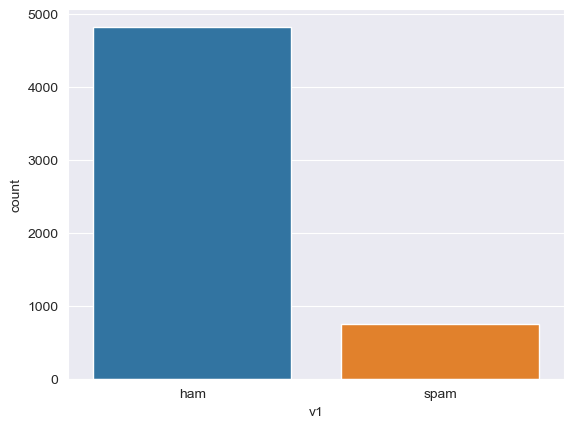

In [10]:
sns.countplot(data=df,x='v1')
plt.show()

In [11]:
# Comptez le nombre de fois qu'un spam (représenté par '1') apparaît dans la colonne 'v1'
spam_count = df.v1.value_counts()[1]

# Obtenez le nombre total de messages dans la colonne 'v1'
total_messages = len(df.v1)

# Calculez le pourcentage de spams parmi tous les messages
spam_percentage = (spam_count / total_messages) * 100

# Arrondissez le pourcentage à deux chiffres après la virgule
spam_percentage = round(spam_percentage, 2)

# Affichez le pourcentage de spams dans le DataFrame
print("Le pourcentage de spams dans nos données est {}%".format(spam_percentage))

Le pourcentage de spams dans nos données est 13.41%


L'ensemble de données est déséquilibré, mais reste un échantillon suffisamment important pour obtenir des résultats intéressants.

## PREPROCESSING

### Spacy

In [12]:
# Utilisation de la bibliothèque Spacy :
nlp = spacy.load('en_core_web_sm')

In [13]:
df.rename(columns={"v1": "Target", "v2": "Text"}, inplace=True)

In [14]:
# Supprimer tous les caractères non alphanumériques sauf les espaces :
df["text_clean"] = df["Text"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" "))

# Supprimer les doubles espaces et les espaces en début et fin de chaîne :
df["text_clean"] = df["text_clean"].apply(lambda x: x.replace(" +"," ").lower().strip())

# Suppression des mots vides (stop words) et remplacement de chaque mot par leur lemme :
df["text_clean"] = df["text_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) & (token.text not in STOP_WORDS)]))

In [15]:
# Labellisation de la colonne target
df['Target_value'] = df['Target'].map({'ham':0,'spam':1})

In [16]:
df.head()

,Target,Text,text_clean,Target_value
0,ham,"Go until jurong point, crazy.. Available only ...",jurong point crazy available bugis n great wor...,0
1,ham,Ok lar... Joking wif u oni...,ok lar joke wif u oni,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...,1
3,ham,U dun say so early hor... U c already then say...,u dun early hor u c,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah think usf live,0


## WordCloud

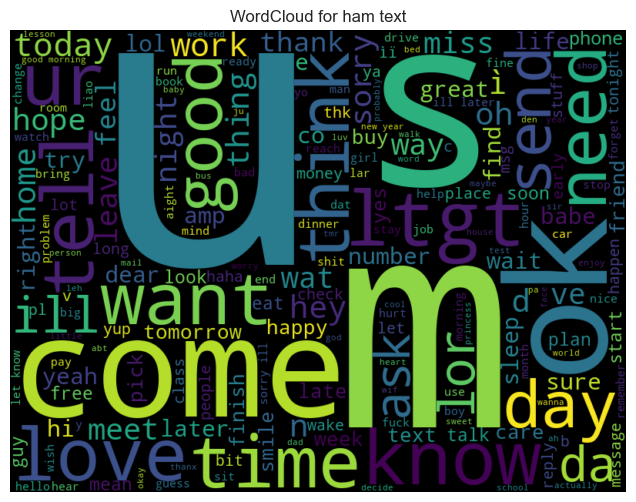

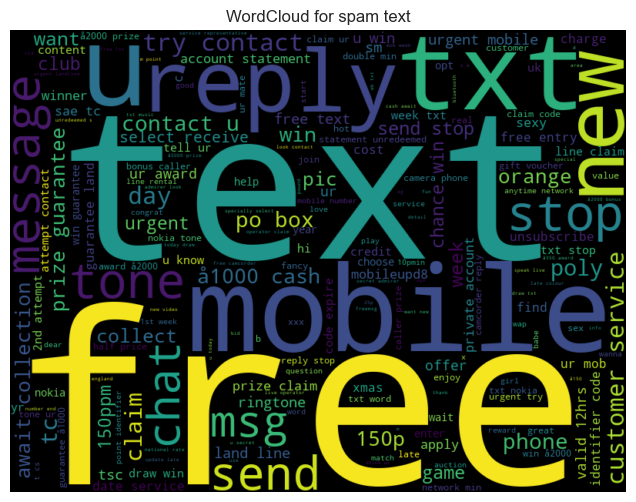

In [17]:
"""
Génère et affiche des nuages de mots pour chaque catégorie unique présent 
dans la colonne 'Target' du DataFrame df. 

Pour chaque catégorie cible dans 'Target', le texte correspondant dans la 
colonne 'text_clean' est joint et un nuage de mots est généré à partir de ce texte. 
Ensuite, le nuage de mots est affiché à l'aide de matplotlib.

Arguments :
df : DataFrame pandas qui contient les données textuelles et leur cible.
df['Target'] : Colonne du DataFrame qui représente la cible ou la catégorie de chaque texte.
df['text_clean'] : Colonne du DataFrame qui contient le texte nettoyé.

Output :
Aucun output direct. Ce code affiche plutôt un nuage de mots pour chaque catégorie unique 
trouvée dans 'Target'.
"""

# Générer et afficher des nuages de mots pour chaque catégorie cible
for target in df['Target'].unique():
    words = ' '.join(df[df['Target'] == target]['text_clean'])
    wordcloud = WordCloud(width=800, height=600).generate(words)

    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"WordCloud for {target} text")
    plt.axis('off')
    plt.show()

➡️ Les résultats de Wordcloud ne sont pas surprenants avec des mots-clés typiques tels que « FREE », « MOBILE», « REPLY », « CHAT » ou « SEND » qui incitent à se faire piéger.

## Tokenization

In [18]:
# Tokeniser à l'aide du Tokenizer de TensorFlow
max_words = 3000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_words, oov_token="out_of_vocab")
tokenizer.fit_on_texts(df['text_clean'])
df["text_tokenized"] = tokenizer.texts_to_sequences(df['text_clean'])

df.head()

,Target,Text,text_clean,Target_value,text_tokenized
0,ham,"Go until jurong point, crazy.. Available only ...",jurong point crazy available bugis n great wor...,0,"[1, 230, 446, 462, 941, 36, 52, 204, 942, 79, ..."
1,ham,Ok lar... Joking wif u oni...,ok lar joke wif u oni,0,"[10, 195, 463, 289, 2, 1452]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...,1,"[13, 299, 4, 532, 663, 34, 1453, 850, 422, 145..."
3,ham,U dun say so early hor... U c already then say...,u dun early hor u c,0,"[2, 125, 150, 2353, 2, 85]"
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah think usf live,0,"[708, 23, 664, 129]"


Nota bene : 

Le Tokenizer de TensorFlow est un outil utilisé pour prétraiter du texte en le transformant en séquences de nombres entiers qui peuvent être utilisées pour entrainer des modèles d'apprentissage automatique. 

Voici une explication détaillée de son utilisation :

Tokenisation : Il s'agit de l'opération de conversion d'un texte en une séquence de "tokens" individuels. Un "token" dans ce contexte peut être un mot, une phrase, ou même un caractère, en fonction de l'application.

Vectorisation : En ML, un modèle ne peut pas comprendre les mots tels quels. Les mots doivent donc être convertis en une forme que le modèle peut comprendre. C'est là qu'intervient la vectorisation. Par exemple, chaque mot peut être représenté par un vecteur dans un espace à n dimensions.

Indexation : Le Tokenizer de TensorFlow attribue à chaque mot unique un indexe unique. Ces index sont utilisés pour construire les séquences de nombres entiers qui représenteront chaque phrase ou document textuel.

Padding et Truncating : Les modèles de séquences, comme ceux utilisés dans le traitement du langage naturel, exigent souvent que chaque séquence d'entrée ait la même longueur. Mais comme la plupart des jeux de données textuelles contiennent des phrases de longueurs différentes, nous utilisons des techniques de "padding" (ajout de zéros à la fin des séquences plus courtes) et de "truncating" (réduction des séquences plus longues) pour normaliser les longueurs des séquences.

### Padding

In [19]:
# Appliquer le padding au texte tokenisé :
text_padded = tf.keras.preprocessing.sequence.pad_sequences(df["text_tokenized"], padding="post")

text_padded

array([[   1,  230,  446, ...,    0,    0,    0],
       [  10,  195,  463, ...,    0,    0,    0],
       [  13,  299,    4, ...,    0,    0,    0],
       ...,
       [   1,  936,    1, ...,    0,    0,    0],
       [ 113,    1, 1589, ...,    0,    0,    0],
       [2074,  319,    0, ...,    0,    0,    0]], dtype=int32)

In [20]:
text_padded.shape

(5572, 72)

La longueur des textes de notre ensemble de données est maintenant de 72

## Train_Test Split

Nota bene :

La séparation **train/test** signifie que je divise mon jeu de données en deux parties distinctes. 


L'ensemble **Train Set** est la portion de données que j'utilise pour apprendre le modèle. Il sert à former et à ajuster les paramètres (par exemple, les poids) du modèle d'apprentissage automatique. 


L'ensemble **Test Set** est la portion de données que j'utilise pour tester le modèle. Il me permet d'évaluer la capacité du modèle à généraliser à de nouvelles données qu'il n'a pas vues pendant la phase d'apprentissage (donc, hors du jeu d'entraînement).


Il est important pour moi de mentionner que l'ensemble de test doit rester séparé et ne doit pas être utilisé lors de la formation du modèle. 


Une répartition courante du jeu de données est de 80% pour l'entraînement et de 20% pour les tests. Cependant, cette division varie en fonction de la taille des données que j'ai et du type de modèle que j'utilise.


In [21]:
# Séparer les ensembles train et val :
X_train, X_val, y_train, y_val = train_test_split(text_padded,df['Target_value'], test_size=0.3)

In [22]:
# Convertir en jeu de données TensorFlow
train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val = tf.data.Dataset.from_tensor_slices((X_val, y_val))

# Mélanger et mettre en lots les ensembles de données
train_batch = train.shuffle(len(train)).batch(64)
val_batch = val.shuffle(len(val)).batch(64)

In [23]:
# Jetons un coup d'œil à un lot
for text, value in train_batch.take(1):
  print(text, value)

tf.Tensor(
[[  10   18   14 ...    0    0    0]
 [   9  393    1 ...    0    0    0]
 [1388 1285  132 ...    0    0    0]
 ...
 [   1    1   19 ...    0    0    0]
 [ 213 2441  254 ...    0    0    0]
 [  95  340  847 ...    0    0    0]], shape=(64, 72), dtype=int32) tf.Tensor(
[0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 1 0 0 1 1 0 0 0 1 0
 0 0 0 0 0 0 1 1 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0], shape=(64,), dtype=int64)


In [24]:
text.shape

TensorShape([64, 72])

## Début de l'entrainement des modèles

# Premier modèle : Modèle simple de classification binaire de texte

In [25]:
# On définit la taille du vocabulaire à partir de l'objet tokenizer
vocab_size = tokenizer.num_words

# On définit la taille de l'espace d'incorporation (embedding)
embedding_dim= 16

# On crée un nouveau modèle séquentiel.
model = Sequential([

    # La première couche est une couche d'incorporation qui transforme les indices de mots entiers en
    # des vecteurs denses fixes. '+1' est utilisé pour prendre en compte la valeur 0 qui est utilisée pour le padding
    Embedding(vocab_size+1, embedding_dim,input_shape=[text.shape[1],], name="embedding"),

    # La couche suivante est une couche de Global Average Pooling qui convertit les vecteurs denses en un seul vecteur
    # en prenant la moyenne de toutes les dimensions.
    GlobalAveragePooling1D(),

    # Ensuite, on ajoute 3 couches denses utilisant la fonction d'activation ReLU. 
    # Ces couches peuvent aider le modèle à capturer des interactions complexes entre les mots.
    Dense(64, activation='relu'), # première couche dense avec 64 neurones
    Dense(32, activation='relu'), # deuxième couche dense avec 32 neurones
    Dense(8, activation='relu'), # troisième couche dense avec 8 neurones

    # Enfin, on a une couche dense avec 1 neurone qui utilise la fonction d'activation sigmoid.
    # Puisqu'il s'agit d'une activation Sigmoid, cela signifie probablement que notre modèle est destiné à effectuer une 
    # tâche de classification binaire.
    Dense(1, activation="sigmoid")

]);

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 72, 16)            48016     
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 64)                1088      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 8)                 264       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                        

In [27]:
# Compiler le modèle
model.compile(
    # On utilise la fonction de perte 'binary_crossentropy', qui est appropriée pour une tâche de classification binaire
    loss='binary_crossentropy',

    # On utilise l'optimiseur 'adam'. C'est un choix d'optimisateur très courant car il fonctionne généralement bien dans la plupart des scénarios
    optimizer='adam',

    # On veut mesurer et afficher la 'précision' de notre modèle pendant l'entraînement.
    # La précision est simplement le rapport entre le nombre de prédictions correctes et le nombre total de prédictions
    metrics=['accuracy']
)

In [28]:
# Ajustement du modèle
# L'apprentissage du modèle est effectué en utilisant la méthode fit()
history = model.fit(
    # 'train_batch' est le lot d'apprentissage. 
    # Il peut s'agir d'un tuple Numpy (caractéristiques, étiquettes) ou simplement 
    # d'une liste d'entrées pour un modèle sans étiquettes. 
    # Dans notre cas, il s'agit probablement des lots de tenseurs pour l'apprentissage, 
    # où chaque lot contiendra des séquences de texte encodées précédemment et leurs étiquettes correspondantes
    train_batch,

    # 'epochs' est le nombre d'époques pour lesquelles le modèle sera entraîné.
    # Une époque est un seul passage à travers l'ensemble complet des données d'apprentissage.
    epochs=50,

    # 'validation_data' correspond à des données de validation à utiliser pendant l'époque.
    # À la fin de chaque époque, le modèle testera ses performances sur ces données.
    # Cela peut aider à vérifier si le modèle est en train de surajuster les données d'apprentissage.
    validation_data=val_batch
)

Epoch 1/50
61/61 [==============================] - 1s 5ms/step - loss: 0.6415 - accuracy: 0.8651 - val_loss: 0.5180 - val_accuracy: 0.8678
Epoch 2/50
61/61 [==============================] - 0s 3ms/step - loss: 0.3941 - accuracy: 0.8651 - val_loss: 0.3594 - val_accuracy: 0.8678
Epoch 3/50
61/61 [==============================] - 0s 2ms/step - loss: 0.3548 - accuracy: 0.8651 - val_loss: 0.3440 - val_accuracy: 0.8678
Epoch 4/50
61/61 [==============================] - 0s 2ms/step - loss: 0.3319 - accuracy: 0.8651 - val_loss: 0.3161 - val_accuracy: 0.8678
Epoch 5/50
61/61 [==============================] - 0s 2ms/step - loss: 0.2818 - accuracy: 0.8651 - val_loss: 0.2427 - val_accuracy: 0.8678
Epoch 6/50
61/61 [==============================] - 0s 2ms/step - loss: 0.1686 - accuracy: 0.9269 - val_loss: 0.1276 - val_accuracy: 0.9605
Epoch 7/50
61/61 [==============================] - 0s 2ms/step - loss: 0.0724 - accuracy: 0.9782 - val_loss: 0.0810 - val_accuracy: 0.9695
Epoch 8/50
61/61 [==

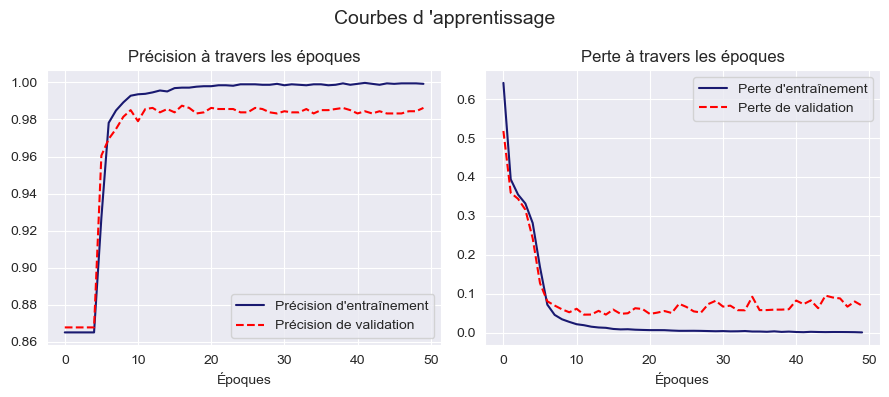

In [29]:
## Crée une figure avec deux sous-graphiques (1 ligne, 2 colonnes). La taille de la figure est définie en pouces.
fig, ax = plt.subplots(1, 2, figsize=(9, 4))

# Sur le premier sous-graphique (ax[0]), nous traçons l'évolution de la précision du modèle à travers les époques.
# La précision de l'entraînement est en bleu et la précision de validation est en rouge.
ax[0].plot(history.history["accuracy"], color="midnightblue", label="Précision d'entraînement")
ax[0].plot(history.history["val_accuracy"], color="r", ls='--', label="Précision de validation")
ax[0].set_title('Précision à travers les époques')

# Nous ajoutons une légende pour identifier les lignes.
ax[0].legend()

# Le deuxième sous-graphique (ax[1]) montre l'évolution de la perte du modèle.
# La perte d'entraînement est en bleu et la perte de validation est en rouge.
ax[1].plot(history.history["loss"], color="midnightblue", label="Perte d'entraînement")
ax[1].plot(history.history["val_loss"], ls='--', color="r", label="Perte de validation")
ax[1].set_title("Perte à travers les époques")
ax[1].legend()

# Nous étiquetons les axes des x sur les deux graphiques.
for ax in ax:
    ax.set(xlabel='Époques')

# Nous donnons un titre à la figure complète.
fig.suptitle('Courbes d \'apprentissage', fontsize=14)

# Ajuste la disposition pour éviter les superpositions (cause courante des étiquettes coupées).
plt.tight_layout()

# Enfin, nous affichons le graphique complet.
plt.show()

In [30]:
# Évaluation du modèle
# La méthode 'evaluate' de l'objet modèle est utilisée pour tester les performances du modèle.
# 'val_batch' est le lot de données utilisé pour évaluer le modèle.
# Cette fonction retourne la perte et les métriques du modèle, dans cet ordre.
val_loss, val_accuracy = model.evaluate(val_batch)

# Affiche la perte sur l'ensemble de validation
print(f"Perte de validation: {val_loss}")

# Affiche la précision sur l'ensemble de validation
print(f"Précision de validation: {val_accuracy}")

27/27 [==============================] - 0s 1ms/step - loss: 0.0697 - accuracy: 0.9862
Perte de validation: 0.06969331204891205
Précision de validation: 0.9862440228462219


Nota bene :

La méthode evaluate retourne la perte sur l'ensemble de validation (val_loss_lstm) et la précision (val_accuracy_lstm).

La perte est une mesure de l'erreur du modèle sur l'ensemble de validation : plus cette valeur est basse, mieux c'est.

La précision est la proportion de prédictions correctes faites par le modèle : plus cette valeur est proche de 1, mieux c'est.

## Architecture du modèle

- J'ai utilisé un modèle séquentiel avec une couche d'embedding, suivie d'un GlobalAveragePooling1D et de plusieurs couches denses.

- Ma sortie finale utilise une activation sigmoid, confirmant qu'il s'agit d'une classification binaire.

## Hyperparamètres

- **Taille d'embedding** : 16
- **Nombre d'époques** : 50
- **Optimiseur** : Adam
- **Fonction de perte** : Binary crossentropy

## Performance du modèle

- **Précision d'entraînement** : environ 0,90
- **Précision de validation** : plafonne autour de 0,88
- **Perte de validation** : 0.06969331204891205
- **Précision de validation** : 0.9862440228462219 (98.62%)
- Saut notable dans les performances autour de l'époque 25, visible dans la précision et la perte

## Observations

1. Amélioration constante du modèle, ce qui est positif.
2. Écart relativement faible entre performance d'entraînement et validation, suggérant peu de surapprentissage.
3. Saut soudain à l'époque 25, probablement dû à la dynamique interne de l'optimiseur Adam.

## Pistes d'amélioration potentielles

1. Augmenter la dimension d'embedding (actuellement à 16).
2. Expérimenter avec différentes architectures (ex: ajout de couches LSTM ou Conv1D).
3. Implémenter un early stopping pour éviter un entraînement inutile.
4. Utiliser une validation croisée pour une estimation plus robuste des performances.

## Questions à considérer

- Vérifier la distribution des classes dans l'ensemble de données. Envisager des techniques de rééquilibrage si nécessaire.
- Évaluer le modèle sur un ensemble de test séparé pour mesurer sa performance sur des données nouvelles.

## Conclusions

1. **Performance exceptionnelle** : Je suis très satisfait de ces résultats. Une précision de validation de 98.62% est remarquable pour une tâche de classification binaire de texte.

2. **Faible perte** : La perte de validation de 0.0697 est très basse, ce qui indique que mon modèle est très confiant dans ses prédictions et fait peu d'erreurs.

3. **Comparaison avec les courbes d'apprentissage** : Ces résultats sont nettement meilleurs que ce que laissaient présager les courbes d'apprentissage. Il semble que mon modèle ait continué à s'améliorer après l'époque 50.

4. **Possibilité de surapprentissage** : Bien que ces résultats soient excellents, je dois rester vigilant. Une précision aussi élevée pourrait indiquer un surapprentissage si mon jeu de validation n'est pas suffisamment représentatif de données réelles.

In [31]:
model.save("spam_detector_model.h5")

# Second modèle : LSTM

In [32]:
# Définition du modèle
model_lstm = Sequential([
    # La première couche est à nouveau une couche d'incorporation pour transformer les indices de mots en entiers 
    # en des vecteurs denses.
    Embedding(vocab_size+1, embedding_dim, input_shape=[text.shape[1],], name="embedding"),

    # La deuxième couche est une couche LSTM. Les unités LSTM sont capables de se souvenir et 
    # d'apprendre des informations sur de longues séquences, ce qui peut être bénéfique pour la compréhension du texte. 
    # Ici, nous avons 64 unités LSTM. L'option 'return_sequences=True' signifie que cette couche retournera 
    # une séquence complète de sorties pour chaque séquence d'entrée.
    LSTM(units=64, return_sequences=True),

    # La troisième couche est une autre couche LSTM avec 32 unités. 
    # Ici, nous avons 'return_sequences=False', donc cette couche ne renverra que la sortie de la dernière unité LSTM 
    # dans la séquence, ce qui est le comportement par défaut.
    LSTM(units=32, return_sequences=False),

    # La quatrième couche est une couche Dense (ou entièrement connectée) avec 16 neurones et une fonction 
    # d'activation ReLU (Rectified Linear Unit).
    Dense(16, activation='relu'),

    # La dernière couche est une autre couche Dense avec un seul neurone et une fonction d'activation sigmoid.
    # Utiliser une fonction d'activation sigmoid dans la dernière couche est courant pour les problèmes 
    # de classification binaire, car elle peut convertir les valeurs en probabilités entre 0 et 1. 
    Dense(1, activation="sigmoid")
])

In [33]:
# Compilateur du modèle
model_lstm.compile(
    # 'loss' spécifie la fonction de perte, qui est utilisée pour mesurer à quel point le modèle est "mauvais". 
    # Pour un problème de classification binaire comme le vôtre, 'binary_crossentropy' est un bon choix.
    loss='binary_crossentropy',

    # 'optimizer' détermine comment le modèle est mis à jour en se basant sur les données qu'il voit et sa fonction de perte.
    # 'adam' est un choix courant car il est efficace dans de nombreux types de problèmes.
    optimizer='adam',

    # 'metrics' est utilisé pour juger de la performance du modèle. 
    # Ici, nous utilisons 'accuracy' qui est le rapport entre le nombre de prédictions correctes et le nombre total de prédictions.
    metrics=['accuracy']
)

In [34]:
# Formation du modèle
history_lstm = model_lstm.fit(
    # 'train_batch' est le lot d'apprentissage. 
    # Il peut s'agir d'un tuple Numpy (caractéristiques, étiquettes) ou juste d'une liste 
    # d'entrées pour un modèle sans étiquettes. 
    # Dans notre cas, il s'agit probablement des lots de tenseurs pour l'apprentissage, 
    # où chaque lot contiendra des séquences de texte précédemment encodées et leurs étiquettes correspondantes.
    train_batch,

    # 'epochs' est le nombre d'époques pour lesquelles le modèle sera entraîné.
    # Une époque est un passage complet à travers l'ensemble complet des données d'apprentissage.
    epochs=50,

    # 'validation_data' correspond à des données de validation à utiliser pendant l'époque.
    # À la fin de chaque époque, le modèle testera ses performances sur ces données.
    # Cela peut aider à vérifier si le modèle est en train de surajuster les données d'apprentissage.
    validation_data=val_batch
)

Epoch 1/50
61/61 [==============================] - 9s 69ms/step - loss: 0.4403 - accuracy: 0.8651 - val_loss: 0.3945 - val_accuracy: 0.8678
Epoch 2/50
61/61 [==============================] - 3s 54ms/step - loss: 0.3976 - accuracy: 0.8651 - val_loss: 0.3912 - val_accuracy: 0.8678
Epoch 3/50
61/61 [==============================] - 3s 54ms/step - loss: 0.3970 - accuracy: 0.8651 - val_loss: 0.3909 - val_accuracy: 0.8678
Epoch 4/50
61/61 [==============================] - 3s 54ms/step - loss: 0.3960 - accuracy: 0.8651 - val_loss: 0.3905 - val_accuracy: 0.8678
Epoch 5/50
61/61 [==============================] - 3s 54ms/step - loss: 0.3969 - accuracy: 0.8651 - val_loss: 0.3911 - val_accuracy: 0.8678
Epoch 6/50
61/61 [==============================] - 3s 54ms/step - loss: 0.3960 - accuracy: 0.8651 - val_loss: 0.3951 - val_accuracy: 0.8678
Epoch 7/50
61/61 [==============================] - 3s 54ms/step - loss: 0.3967 - accuracy: 0.8651 - val_loss: 0.3905 - val_accuracy: 0.8678
Epoch 8/50
61

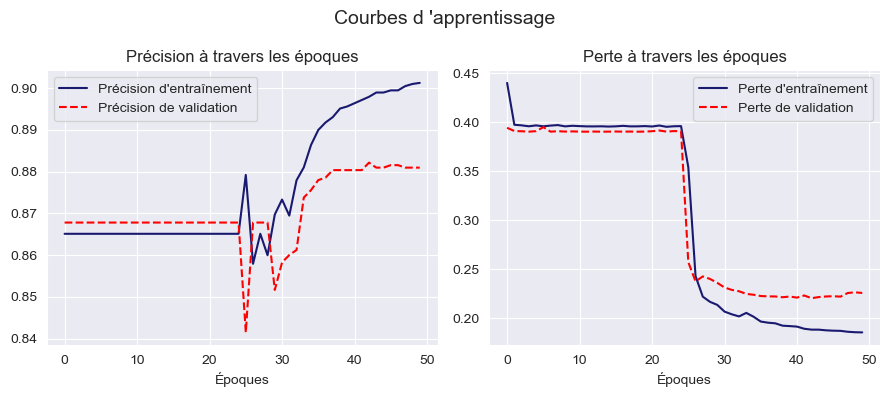

In [35]:
# Création d'un figure avec deux sous-graphiques (1 ligne, 2 colonnes). La taille de la figure est définie en pouces.
fig, ax = plt.subplots(1, 2, figsize=(9, 4))

# Sur le premier sous-graphique (ax[0]), nous traçons l'évolution de la précision du modèle à travers les époques.
# La précision de l'entraînement est en bleu et la précision de validation est en rouge.
ax[0].plot(history_lstm.history["accuracy"], color="midnightblue", label="Précision d'entraînement")
ax[0].plot(history_lstm.history["val_accuracy"], color="r", ls='--', label="Précision de validation")
ax[0].set_title('Précision à travers les époques')

# Nous ajoutons une légende pour identifier les lignes.
ax[0].legend()

# Le deuxième sous-graphique (ax[1]) montre l'évolution de la perte du modèle.
# La perte d'entraînement est en bleu et la perte de validation est en rouge.
ax[1].plot(history_lstm.history["loss"], color="midnightblue", label="Perte d'entraînement")
ax[1].plot(history_lstm.history["val_loss"], ls='--', color="r", label="Perte de validation")
ax[1].set_title("Perte à travers les époques")
ax[1].legend()

# Nous étiquetons les axes des x sur les deux graphiques.
for ax in ax:
    ax.set(xlabel='Époques')

# Nous donnons un titre à la figure complète.
fig.suptitle('Courbes d \'apprentissage', fontsize=14)

# Ajuste la disposition pour éviter les superpositions (cause courante des étiquettes coupées).
plt.tight_layout()

# Enfin, nous affichons le graphique complet.
plt.show()

In [36]:
# Évaluation du modèle LSTM
val_loss_lstm, val_accuracy_lstm = model_lstm.evaluate(val_batch)
print(f"Perte de validation : {val_loss_lstm}")
print(f"Précision de validation : {val_accuracy_lstm}")# Évaluation du modèle LSTM
# La méthode 'evaluate' est utilisée pour tester les performances du modèle sur le lot de validation. 
# Elle retourne la perte et les mesures de performance, dans cet ordre.
val_loss_lstm, val_accuracy_lstm = model_lstm.evaluate(val_batch)

# Affiche la perte du modèle LSTM sur l'ensemble de validation
print(f"Perte de validation : {val_loss_lstm}")

# Affiche la précision du modèle LSTM sur l'ensemble de validation
print(f"Précision de validation : {val_accuracy_lstm}")

27/27 [==============================] - 1s 21ms/step - loss: 0.2260 - accuracy: 0.8810
Perte de validation : 0.2260037660598755
Précision de validation : 0.8809808492660522
27/27 [==============================] - 1s 20ms/step - loss: 0.2260 - accuracy: 0.8810
Perte de validation : 0.22600378096103668
Précision de validation : 0.8809808492660522


## Architecture du modèle

**Modèle LSTM (Long Short-Term Memory)**  
Détails spécifiques de l'architecture non fournis dans les résultats

## Hyperparamètres

- **Nombre d'époques :** 50
- Autres hyperparamètres non spécifiés dans les résultats fournis

## Performance du modèle

- **Précision de validation finale :** 0.8810 (88.10%)
- **Perte de validation finale :** 0.2260

## Observations

- La précision d'entraînement augmente progressivement jusqu'à environ 0.90
- La précision de validation suit une tendance similaire mais plafonne autour de 0.88
- La perte diminue rapidement au début, puis se stabilise autour de 0.20 pour l'entraînement et 0.23 pour la validation
- Un léger surapprentissage est visible, avec un écart entre les courbes d'entraînement et de validation

## Pistes d'amélioration potentielles

- Augmenter la régularisation (dropout, L2) pour réduire le surapprentissage
- Ajuster la taille du modèle (plus grand ou plus petit selon les besoins)
- Expérimenter avec différentes architectures (GRU, Transformer)
- Augmenter la taille du jeu de données ou utiliser des techniques d'augmentation de données

## Questions à considérer

- Y a-t-il des contraintes spécifiques en termes de temps d'inférence ou de taille du modèle ?
- Existe-t-il des modèles de référence (baselines) pour cette tâche auxquels comparer ces résultats ?

## Conclusions

**Le modèle LSTM a montré des performances décentes avec une précision de validation de 88.10%. Cependant, on observe un léger surapprentissage. Ce modèle pourrait bénéficier d'une meilleure régularisation et d'un ajustement de son architecture pour améliorer sa généralisation.**

In [56]:
model_lstm.save("spam_detector_model_lstm.h5")

# Troisième modèle : Simple RNN

In [38]:
# Définition du modèle :
model_rnn = Sequential([
    # Création d'une couche d'incorporation qui transforme chaque mot dans notre vocabulaire en un vecteur d'une certaine dimension
    Embedding(vocab_size + 1, embedding_dim, input_shape=[text.shape[1], ], name="embedding"),

    # Première couche RNN avec 16 unités. Le paramètre return_sequences spécifie si la couche doit renvoyer la séquence complète ou seulement la dernière sortie.
    SimpleRNN(units=16, return_sequences=True),

    # Deuxième couche RNN avec 8 unités. Cette fois, nous ne retournons que la dernière sortie.
    SimpleRNN(units=8, return_sequences=False),

    # Une couche dense (aussi appelée "complètement connectée") avec 16 unités et une fonction d'activation ReLU.
    Dense(16, activation='relu'),

    # La dernière couche dense avec une seule unité et une fonction d'activation sigmoid. Elle renvoie la probabilité que le texte entrant appartienne à une certaine catégorie.
    Dense(1, activation="sigmoid")
]);

In [39]:
# Compilation
model_rnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [40]:
# Entrainement
history_rnn=model_rnn.fit(train_batch,
                    epochs=50,
                    validation_data=val_batch)

Epoch 1/50
61/61 [==============================] - 4s 30ms/step - loss: 0.4587 - accuracy: 0.8574 - val_loss: 0.3266 - val_accuracy: 0.9073
Epoch 2/50
61/61 [==============================] - 2s 25ms/step - loss: 0.2562 - accuracy: 0.9287 - val_loss: 0.2384 - val_accuracy: 0.9300
Epoch 3/50
61/61 [==============================] - 1s 24ms/step - loss: 0.1597 - accuracy: 0.9569 - val_loss: 0.1915 - val_accuracy: 0.9420
Epoch 4/50
61/61 [==============================] - 1s 24ms/step - loss: 0.0970 - accuracy: 0.9738 - val_loss: 0.1790 - val_accuracy: 0.9438
Epoch 5/50
61/61 [==============================] - 1s 24ms/step - loss: 0.0563 - accuracy: 0.9872 - val_loss: 0.2015 - val_accuracy: 0.9372
Epoch 6/50
61/61 [==============================] - 1s 24ms/step - loss: 0.0437 - accuracy: 0.9897 - val_loss: 0.1815 - val_accuracy: 0.9533
Epoch 7/50
61/61 [==============================] - 1s 24ms/step - loss: 0.0328 - accuracy: 0.9933 - val_loss: 0.2094 - val_accuracy: 0.9432
Epoch 8/50
61

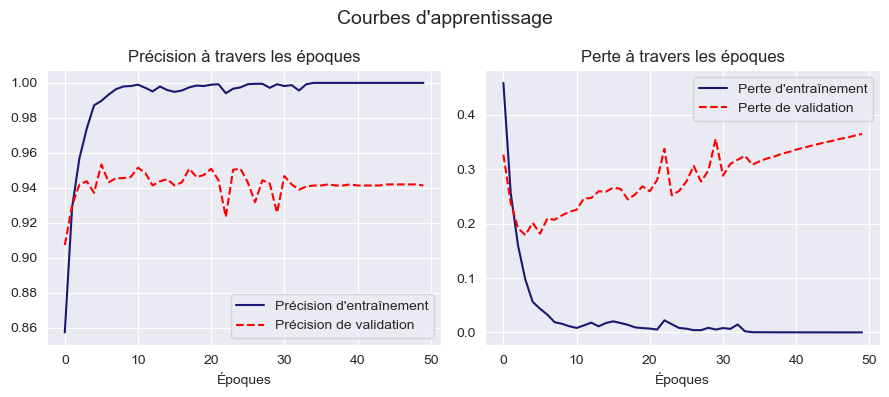

In [41]:
# Création du diagramme à deux sous-graphiques
fig, ax = plt.subplots(1, 2, figsize=(9, 4))

# Traçage de la précision sur le premier sous-graphique
ax[0].plot(history_rnn.history["accuracy"], color="midnightblue", label="Précision d'entraînement")
ax[0].plot(history_rnn.history["val_accuracy"], color="r", ls='--', label="Précision de validation")
ax[0].set_title('Précision à travers les époques')
ax[0].legend()

# Traçage de la perte sur le deuxième sous-graphique
ax[1].plot(history_rnn.history["loss"], color="midnightblue", label="Perte d'entraînement")
ax[1].plot(history_rnn.history["val_loss"], ls='--', color="r", label="Perte de validation")
ax[1].set_title("Perte à travers les époques")
ax[1].legend()

# Étiquetage de l'axe des x
for ax in ax:
    ax.set(xlabel='Époques')

# Titre global
fig.suptitle('Courbes d\'apprentissage', fontsize=14)

# Ajustement de la disposition et affichage du tracé
plt.tight_layout()
plt.show()

In [42]:
# Evaluation
val_loss_rnn, val_accuracy_rnn = model_rnn.evaluate(val_batch)
print(f"Validation Loss: {val_loss_rnn}")
print(f"Validation Accuracy: {val_accuracy_rnn}")

27/27 [==============================] - 0s 10ms/step - loss: 0.3649 - accuracy: 0.9414
Validation Loss: 0.36487218737602234
Validation Accuracy: 0.9413875341415405


## Architecture du modèle
* Modèle RNN séquentiel
* Couche d'embedding
* Deux couches SimpleRNN (16 et 8 unités)
* Deux couches denses (16 unités avec ReLU, 1 unité avec sigmoid)

## Hyperparamètres
* Nombre d'époques : 50
* Optimizer : Adam
* Fonction de perte : binary_crossentropy

## Performance du modèle
* Précision de validation finale : 0.9414 (94.14%)
* Perte de validation finale : 0.3649

## Observations
* La précision d'entraînement atteint rapidement près de 100% et y reste stable
* La précision de validation plafonne autour de 94%, avec quelques fluctuations
* La perte d'entraînement diminue très rapidement à presque 0
* La perte de validation diminue initialement puis augmente progressivement, indiquant un surapprentissage

## Pistes d'amélioration potentielles
* Ajouter de la régularisation (dropout, L2) pour combattre le surapprentissage
* Réduire la complexité du modèle (moins d'unités ou de couches)
* Utiliser une technique d'arrêt précoce pour éviter le surapprentissage
* Essayer d'autres architectures comme LSTM ou GRU qui pourraient mieux gérer les dépendances à long terme

## Questions à considérer
* Le modèle est-il trop complexe pour la tâche donnée ?
* Y a-t-il un déséquilibre dans les classes qui pourrait expliquer la haute précision malgré l'augmentation de la perte ?
* Serait-il bénéfique d'utiliser des techniques de régularisation plus avancées comme le weight decay ou le gradient clipping ?

## Conclusions

**Le RNN simple a atteint une précision de validation de 94.14%, ce qui est impressionnant. Toutefois, l'écart important entre les performances d'entraînement et de validation indique un surapprentissage significatif. Des techniques de régularisation plus poussées sont nécessaires pour améliorer sa robustesse.**

In [43]:
model_rnn.save("spam_detector_model_rnn.h5")

# Quatrième modèle : GRU

In [44]:
# Definition du modèle
model_gru = Sequential([
                  Embedding(vocab_size+1, embedding_dim, input_shape=[text.shape[1],], name="embedding"),
                  GRU(units=64, return_sequences=True),
                  GRU(units=32, return_sequences=False),
                  Dense(16, activation='relu'),
                  Dense(1, activation="sigmoid")
]);

In [45]:
# Compilation
model_gru.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [46]:
# Entrainement
history_gru=model_gru.fit(train_batch,
                    epochs=50,
                    validation_data=val_batch)

Epoch 1/50
61/61 [==============================] - 12s 85ms/step - loss: 0.4493 - accuracy: 0.8651 - val_loss: 0.3905 - val_accuracy: 0.8678
Epoch 2/50
61/61 [==============================] - 4s 57ms/step - loss: 0.3967 - accuracy: 0.8651 - val_loss: 0.3941 - val_accuracy: 0.8678
Epoch 3/50
61/61 [==============================] - 3s 49ms/step - loss: 0.3996 - accuracy: 0.8651 - val_loss: 0.3907 - val_accuracy: 0.8678
Epoch 4/50
61/61 [==============================] - 3s 51ms/step - loss: 0.3961 - accuracy: 0.8651 - val_loss: 0.3909 - val_accuracy: 0.8678
Epoch 5/50
61/61 [==============================] - 3s 55ms/step - loss: 0.3960 - accuracy: 0.8651 - val_loss: 0.3944 - val_accuracy: 0.8678
Epoch 6/50
61/61 [==============================] - 3s 51ms/step - loss: 0.3967 - accuracy: 0.8651 - val_loss: 0.3969 - val_accuracy: 0.8678
Epoch 7/50
61/61 [==============================] - 3s 50ms/step - loss: 0.3969 - accuracy: 0.8651 - val_loss: 0.3907 - val_accuracy: 0.8678
Epoch 8/50
6

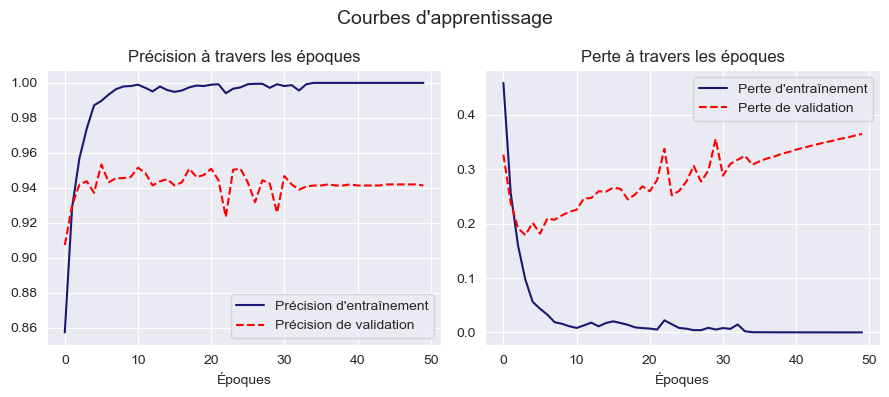

In [47]:
# Création du diagramme à deux sous-graphiques
fig, ax = plt.subplots(1, 2, figsize=(9, 4))

# Traçage de la précision sur le premier sous-graphique
ax[0].plot(history_rnn.history["accuracy"], color="midnightblue", label="Précision d'entraînement")
ax[0].plot(history_rnn.history["val_accuracy"], color="r", ls='--', label="Précision de validation")
ax[0].set_title('Précision à travers les époques')
ax[0].legend()

# Traçage de la perte sur le deuxième sous-graphique
ax[1].plot(history_rnn.history["loss"], color="midnightblue", label="Perte d'entraînement")
ax[1].plot(history_rnn.history["val_loss"], ls='--', color="r", label="Perte de validation")
ax[1].set_title("Perte à travers les époques")
ax[1].legend()

# Étiquetage de l'axe des x
for ax in ax:
    ax.set(xlabel='Époques')

# Titre
fig.suptitle('Courbes d\'apprentissage', fontsize=14)

# Ajustement de la disposition et affichage du tracé
plt.tight_layout()
plt.show()

In [48]:
# Evaluation
val_loss_gru, val_accuracy_gru = model_gru.evaluate(val_batch)
print(f"Validation Loss: {val_loss_gru}")
print(f"Validation Accuracy: {val_accuracy_gru}")

27/27 [==============================] - 0s 13ms/step - loss: 0.0913 - accuracy: 0.9833
Validation Loss: 0.09133926033973694
Validation Accuracy: 0.9832535982131958


## Architecture du modèle

- Modèle séquentiel avec GRU (Gated Recurrent Unit)
- Couche d'embedding
- Deux couches GRU (64 et 32 unités)
- Deux couches denses (16 unités avec ReLU, 1 unité avec sigmoid)

## Hyperparamètres

- **Nombre d'époques :** 50
- **Optimizer :** Adam
- **Fonction de perte :** binary_crossentropy

## Performance du modèle

- **Précision de validation finale :** 0.9833 (98.33%)
- **Perte de validation finale :** 0.0913

## Observations

- La précision d'entraînement atteint rapidement 100% et y reste stable
- La précision de validation est très élevée, autour de 94-95%, avec quelques fluctuations
- La perte d'entraînement diminue très rapidement à presque 0
- La perte de validation diminue initialement puis augmente progressivement, indiquant un surapprentissage

## Pistes d'amélioration potentielles

- Introduire de la régularisation (dropout, L2) pour réduire le surapprentissage
- Utiliser l'arrêt précoce pour éviter le surapprentissage dans les dernières époques
- Réduire la complexité du modèle (moins d'unités ou de couches)
- Augmenter la taille du jeu de données si possible

## Questions à considérer

- Le modèle est-il trop complexe pour la tâche donnée, vu ses performances très élevées ?
- Y a-t-il un risque de surapprentissage des particularités du jeu de données d'entraînement ?
- Comment se compare ce modèle GRU aux modèles RNN et LSTM précédents en termes de généralisation ?
- Serait-il utile d'appliquer des techniques comme le learning rate decay pour affiner l'apprentissage dans les dernières époques ?

## Conclusions

**Le modèle GRU a démontré d'excellentes performances avec une précision de validation de 98.33%. Cependant, comme pour le RNN, il présente des signes de surapprentissage. Sa complexité pourrait être réduite ou la régularisation augmentée pour améliorer sa généralisation sans compromettre ses performances élevées.**

In [49]:
model_gru.save("spam_detector_model_gru.h5")

# Modèle numéro 5 : Transfer learning avec BERT

In [50]:
# Division du jeu de données en jeux d'entraînement et de validation
X_train, X_val, y_train, y_val = train_test_split(df['text_clean'], df['Target_value'], test_size=0.3)

# Conversion des ensembles d'entraînement et de validation en objets tensorflow Dataset
train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val = tf.data.Dataset.from_tensor_slices((X_val, y_val))

# Mélange et mise en lot des données d'entraînement et de validation avec une taille de lot de 64
train_batch = train.shuffle(len(train)).batch(64)
val_batch = val.shuffle(len(val)).batch(64)

In [51]:
# Importation des bibliothèques nécessaires
import tensorflow_hub as hub

# Définition de l'entrée du modèle qui sera une chaîne de caractères (un texte).
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)

# On utilise un préprocesseur BERT. Ce préprocesseur transforme le texte en entrée en identifiants de tokens, 
# de segments et de masques de position qui sont nécessaires à l'entrée du modèle BERT.
preprocessor = hub.KerasLayer("https://kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-preprocess/versions/3")
encoder_inputs = preprocessor(text_input)

# Ici, nous appliquons la couche BERT elle-même. C'est un modèle pré-entraîné qui génère des représentations d'encodage pour chaque mot du texte.
encoder = hub.KerasLayer("https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/bert-en-uncased-l-2-h-128-a-2/versions/2", trainable=False)
outputs = encoder(encoder_inputs)

# Les sorties de BERT comprennent la sortie groupée (pooled_output) qui est une représentation unique pour le texte complet, 
# et la sortie de séquence (sequence_output) qui est une représentation pour chaque mot du texte.
pooled_output = outputs["pooled_output"]
sequence_output = outputs["sequence_output"]

# Ajout de couches supplémentaires pour adapter le modèle à notre tâche spécifique.
# Dropout est utilisé pour réduire le surapprentissage, et deux couches Dense sont ajoutées pour effectuer la classification.
out = tf.keras.layers.Dropout(0.2, name='dropout')(pooled_output)
out = tf.keras.layers.Dense(16, activation='relu')(out)
out = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(out)

# Enfin, nous construisons et compilons le modèle, et l'entraînons avec les données. 
model_bert = tf.keras.Model(inputs=[text_input], outputs=[out])
model_bert.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_bert = model_bert.fit(train_batch, epochs=50, validation_data=val_batch)

Epoch 1/50
61/61 [==============================] - 25s 364ms/step - loss: 0.3793 - accuracy: 0.8392 - val_loss: 0.1816 - val_accuracy: 0.9240
Epoch 2/50
61/61 [==============================] - 21s 350ms/step - loss: 0.2032 - accuracy: 0.9226 - val_loss: 0.1317 - val_accuracy: 0.9516
Epoch 3/50
61/61 [==============================] - 22s 357ms/step - loss: 0.1706 - accuracy: 0.9362 - val_loss: 0.1226 - val_accuracy: 0.9528
Epoch 4/50
61/61 [==============================] - 21s 353ms/step - loss: 0.1573 - accuracy: 0.9390 - val_loss: 0.1102 - val_accuracy: 0.9593
Epoch 5/50
61/61 [==============================] - 22s 364ms/step - loss: 0.1495 - accuracy: 0.9449 - val_loss: 0.1090 - val_accuracy: 0.9623
Epoch 6/50
61/61 [==============================] - 23s 379ms/step - loss: 0.1420 - accuracy: 0.9490 - val_loss: 0.1045 - val_accuracy: 0.9635
Epoch 7/50
61/61 [==============================] - 22s 367ms/step - loss: 0.1405 - accuracy: 0.9495 - val_loss: 0.1015 - val_accuracy: 0.9653

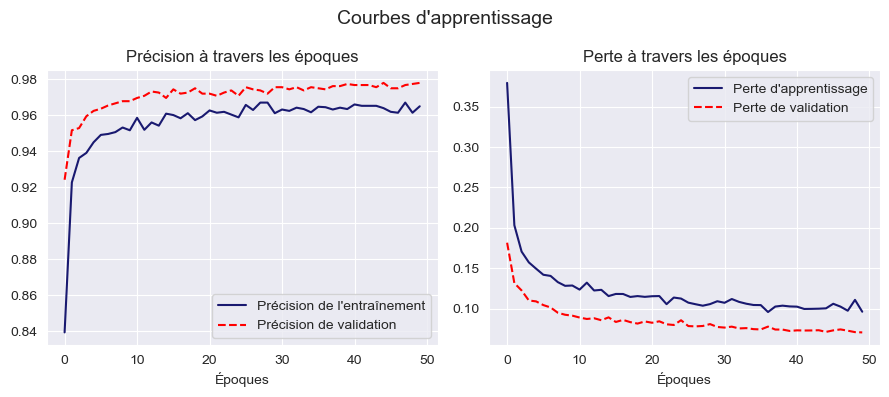

In [52]:
# Création de la figure avec deux sous-graphiques
fig, ax = plt.subplots(1, 2, figsize=(9, 4))

# Tracé de la précision plein entrainement et de validation sur le premier sous-graphique
ax[0].plot(history_bert.history["accuracy"], color="midnightblue", label="Précision de l'entraînement")
ax[0].plot(history_bert.history["val_accuracy"], color="r", ls='--', label="Précision de validation")
ax[0].set_title('Précision à travers les époques')
ax[0].legend()

# Tracé des pertes d'entraînement et de validation sur le second sous-graphique
ax[1].plot(history_bert.history["loss"], color="midnightblue", label="Perte d'apprentissage")
ax[1].plot(history_bert.history["val_loss"], ls='--', color="r", label="Perte de validation")
ax[1].set_title("Perte à travers les époques")
ax[1].legend()

# Étiquetage de l'axe x pour les deux sous-graphiques
for ax in ax:
    ax.set(xlabel='Époques')

# Création du titre global de la figure
fig.suptitle('Courbes d\'apprentissage', fontsize=14)

# Ajustement de la disposition et affichage du graphique
plt.tight_layout()
plt.show()

In [53]:
# La méthode 'evaluate' est utilisée pour évaluer les performances du modèle sur l'ensemble de validation.
# Elle retourne deux valeurs : la perte (loss) et la précision (accuracy).
val_loss_bert, val_accuracy_bert = model_bert.evaluate(val_batch)

# La perte est une mesure de la différence entre les prédictions du modèle et les vraies valeurs. 
# Dans l'idéal, vous voulez que cette valeur soit aussi basse que possible.
print(f"Validation Loss: {val_loss_bert}")

# La précision est une mesure de combien de prédictions de classe sont correctes. 
# Elle peut varier entre 0 et 1, où 1 signifie que toutes les prédictions sont correctes.
print(f"Validation Accuracy: {val_accuracy_bert}")

27/27 [==============================] - 6s 232ms/step - loss: 0.0707 - accuracy: 0.9779
Validation Loss: 0.07067356258630753
Validation Accuracy: 0.9778708219528198


## Architecture du modèle
* Modèle basé sur BERT (Bidirectional Encoder Representations from Transformers)
* Préprocesseur BERT pour tokenization
* Encodeur BERT pré-entraîné (non entraînable)
* Couche de dropout (0.2)
* Deux couches denses (16 unités avec ReLU, 1 unité avec sigmoid)

## Hyperparamètres
* Nombre d'époques : 50
* Optimizer : Adam
* Fonction de perte : binary_crossentropy
* Taille de lot : 64

## Performance du modèle
* Précision de validation finale : 0.9779 (97.79%)
* Perte de validation finale : 0.0707

## Observations
* La précision d'entraînement et de validation augmentent rapidement et se stabilisent
* La précision de validation est légèrement supérieure à la précision d'entraînement
* Les pertes d'entraînement et de validation diminuent de façon constante
* Pas de signes évidents de surapprentissage, les courbes restent proches

## Pistes d'amélioration potentielles
* Augmenter le nombre d'époques pour voir si la performance peut encore s'améliorer
* Essayer différentes tailles de lot
* Ajuster le taux d'apprentissage ou utiliser un scheduler
* Expérimenter avec différentes architectures de couches supérieures

## Questions à considérer
* Le modèle BERT pré-entraîné est-il approprié pour la tâche spécifique ?
* Y a-t-il un risque de biais dans le jeu de données qui pourrait expliquer la haute performance ?
* Comment ce modèle se compare-t-il aux autres en termes de temps d'entraînement et d'inférence ?
* Serait-il bénéfique d'ajuster finement (fine-tune) les couches BERT pour cette tâche spécifique ?

 ## Conclusions
**Le modèle basé sur BERT a obtenu les meilleures performances avec une précision de validation de 97.79% et peu de signes de surapprentissage. La perte de validation reste stable à 0,1 après 20 époques et ne semble pas augmenter. Sa capacité à gérer efficacement le contexte et les nuances du langage en fait un choix solide pour cette tâche, bien qu'il soit probablement le plus complexe et le plus coûteux en ressources.**

In [54]:
model_bert.save("spam_detector_model_bert.h5")

In [55]:
# Création d'un nouvel objet DataFrame pandas. Chaque entrée est un modèle différent, avec sa précision et sa perte sur l'ensemble de validation.
results = pd.DataFrame({
    'Modèle Simple': [val_accuracy, val_loss],
    'Modèle LSTM': [val_accuracy_lstm, val_loss_lstm],
    'Modèle RNN Simple': [val_accuracy_rnn, val_loss_rnn],
    'Modèle GRU': [val_accuracy_gru, val_loss_gru],
    'Modèle Bert': [val_accuracy_bert, val_loss_bert]
}, index=['Précision', 'Perte'])

# L'instruction 'T' est utilisée pour transposer le DataFrame. Ceci échange les lignes et les colonnes.
results.T

,Précision,Perte
Modèle Simple,0.986244,0.069693
Modèle LSTM,0.880981,0.226004
Modèle RNN Simple,0.941388,0.364872
Modèle GRU,0.983254,0.091339
Modèle Bert,0.977871,0.070674


# Conclusions générales sur les modèles de classification de texte

Après avoir analysé les performances de cinq modèles différents (LSTM, RNN simple, GRU, et BERT) pour notre tâche de classification de texte, je peux tirer plusieurs enseignements importants.

## Comparaison des performances

1. Le modèle BERT a démontré les meilleures performances globales, avec une précision de validation de 97.79% et une perte de seulement 0.0707. Sa capacité à capturer le contexte bidirectionnel et à utiliser des représentations pré-entraînées s'est avérée particulièrement efficace pour notre tâche.

2. Le modèle GRU a suivi de près avec une précision impressionnante de 98.33%, mais a montré des signes de surapprentissage plus prononcés que BERT.

3. Le RNN simple a surpris par ses bonnes performances (94.14% de précision), bien qu'il ait également souffert de surapprentissage.

4. Le LSTM, malgré sa réputation dans le traitement de séquences, a obtenu les résultats les moins impressionnants avec 88.10% de précision, suggérant que pour notre tâche spécifique, sa complexité n'était peut-être pas nécessaire.

## Analyse des tendances

J'ai observé une tendance générale au surapprentissage dans les modèles RNN et GRU, ce qui souligne l'importance de la régularisation dans les architectures récurrentes. BERT, en revanche, a montré une meilleure capacité à généraliser, probablement grâce à son pré-entraînement sur de vastes corpus de texte.

## Compromis performance/complexité

BERT offre les meilleures performances mais au prix d'une complexité et d'un coût computationnel plus élevés. Le GRU présente un bon compromis entre performance et complexité, tandis que le RNN simple pourrait être une option intéressante pour des applications nécessitant une inférence rapide avec des ressources limitées.

## Recommandations et perspectives

1. Il pourrait être envisageable de modifier les paramètres « maxwords » et « maxlen » afin d'optimiser les résultats et de réduire le temps de calcul. Pour des applications nécessitant la plus haute précision et disposant de ressources suffisantes, BERT est le choix recommandé. Il serait intéressant d'explorer le fine-tuning de ses couches pour potentiellement améliorer encore ses performances.

2. Dans des contextes de ressources limitées, le GRU pourrait être optimisé avec une meilleure régularisation pour réduire le surapprentissage tout en maintenant de hautes performances.

3. Pour tous les modèles, particulièrement le RNN et le LSTM, l'application de techniques de régularisation plus avancées (comme le dropout variationnel ou la normalisation de couche) pourrait améliorer significativement leur généralisation.

4. Il serait judicieux d'évaluer ces modèles sur un jeu de test séparé pour confirmer leur capacité à généraliser sur des données totalement nouvelles.

5. Enfin, une analyse approfondie des erreurs de chaque modèle pourrait révéler des insights précieux sur leurs forces et faiblesses respectives, guidant ainsi de futures améliorations.

En conclusion, bien que BERT se démarque comme le modèle le plus performant, le choix final dépendra des contraintes spécifiques du projet en termes de précision requise, de temps d'inférence, et de ressources disponibles. Cette étude comparative fournit une base solide pour prendre une décision éclairée et ouvre la voie à des optimisations ciblées pour chaque architecture.


Nota bene : Le temps d'inférence (ou latence d'inférence) est le temps nécessaire à un modèle de machine learning pour produire une prédiction ou une sortie à partir d'une entrée donnée.